In [28]:
import pandas as pd
from sklearn.metrics import accuracy_score
import joblib 


#same preprocessing as in train_def so that we have save structured data
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 3446):
        move = row["Move_"+ str(i)]

        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1
        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index*14
    total_moves = 0
    for i in range(1, 3446):
        move = row["Move_" + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Continue counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves


def mapRaces(races, row_index):
    race = test_data['Race'][row_index]

    if race == "Protoss":
        races[0][row_index] = 1
    elif race == "Terran":
        races[1][row_index] = 1
    elif race == "Zerg":
        races[2][row_index] = 1


# Load new data file 
test_data = pd.read_csv('test_data.csv', delimiter=';')
test_data.columns = ['Race'] + [f'Move_{i}' for i in range(1, 3446)]


# Create new table that only contains the first column (Race) of train_data
# Keep only the first column but all rows
test_data_new = test_data.iloc[:, :1]

# Specify the target time intervals
#time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

calc_column = len(time_intervals)* 14 + 14
# New lists of counts
counts = [[0] * 340 for _ in range(calc_column)]
# New lists of races
races = [[0] * 340 for _ in range(3)]


# Go through the rows using the functions to count the actions, map the races
for row_index, row in test_data.iterrows():
    count_moves(row, counts, row_index)
    mapRaces(races, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)

# Adding all the new columns to the train_data_new
# Adding new columns for the count of moves
for i in range(calc_column):
    locals()[f'count_{i}'] = counts[i]

for i in range(10):
    test_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]

test_data_new['sFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[10])]
test_data_new['baseFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[11])]
test_data_new['singleMineralFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[12])]

# Adding new columns for the count of moves per interval
for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}_Frequency'
        test_data_new[column_name] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + j])]

    test_data_new[f's_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 10])]
    test_data_new[f'base_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 11])]
    test_data_new[f'singleMineral_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 12])]



# Adding new columns for the races
test_data_new['race_Protoss'] = races[0]
test_data_new['race_Terran'] = races[1]
test_data_new['race_Zerg'] = races[2]


# Saving thhem in a csv file
test_data_new.to_csv('actiontype_count_test.csv', index=False)

# print(test_data_new)


# Load the pre-trained model
model_filename = 'player_id_prediction_model.pkl'
clf = joblib.load(model_filename)

features = test_data_new.drop(['Race'], axis=1)




# Use the loaded model to make predictions
predictions = clf.predict(features)

# Add predictions to the test_data_new DataFrame
test_data_new['Predicted_PlayerID'] = predictions

# print(test_data_new)


# Load the training dataset
train_data = pd.read_csv('train_data.csv', delimiter=';')

# Extract 'PlayerID' and 'PlayerURL' columns
player = train_data[['PlayerID', 'PlayerURL']]

# take only one URL per each PlayerID
player_info = player.drop_duplicates(subset='PlayerID', keep='first')

print(player_info)

# Save the result to CSV
player_info.to_csv('player_info.csv', index=False)


# Additional statistics if needed
# For example, you can print the count of each predicted class
print("Count of Predicted PlayerIDs:")
print(test_data_new['Predicted_PlayerID'].value_counts())

# Extract 'Predicted_PlayerID' column
player_id_column = test_data_new[['Predicted_PlayerID']]

print(player_id_column)

# Merge the predicted ID to get the url of the player
result = pd.merge(player_id_column, player_info, left_on='Predicted_PlayerID', right_on='PlayerID', how='left')

# take only the url for each player
result = result.drop(['Predicted_PlayerID', 'PlayerID'], axis=1)
# insert a new row in position 0 as asked for the submission and count the number of lines
result.insert(0,"RowId", range(1, len(result) + 1))

print(result)

# Save 'PlayerURL' to CSV
result.to_csv('player_id_only.csv', index=False)


# Print additional statistics or analysis if needed
print("Count of Unique PlayerURLs:")
print(result['PlayerURL'].nunique())

C:\Users\thekl\AppData\Local\Temp\ipykernel_8292\443702062.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]
C:\Users\thekl\AppData\Local\Temp\ipykernel_8292\443702062.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]
C:\Users\the

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- base_t20_Frequency
- base_t5_Frequency
- hk0_t20_Frequency
- hk0_t5_Frequency
- hk1_t5_Frequency
- ...


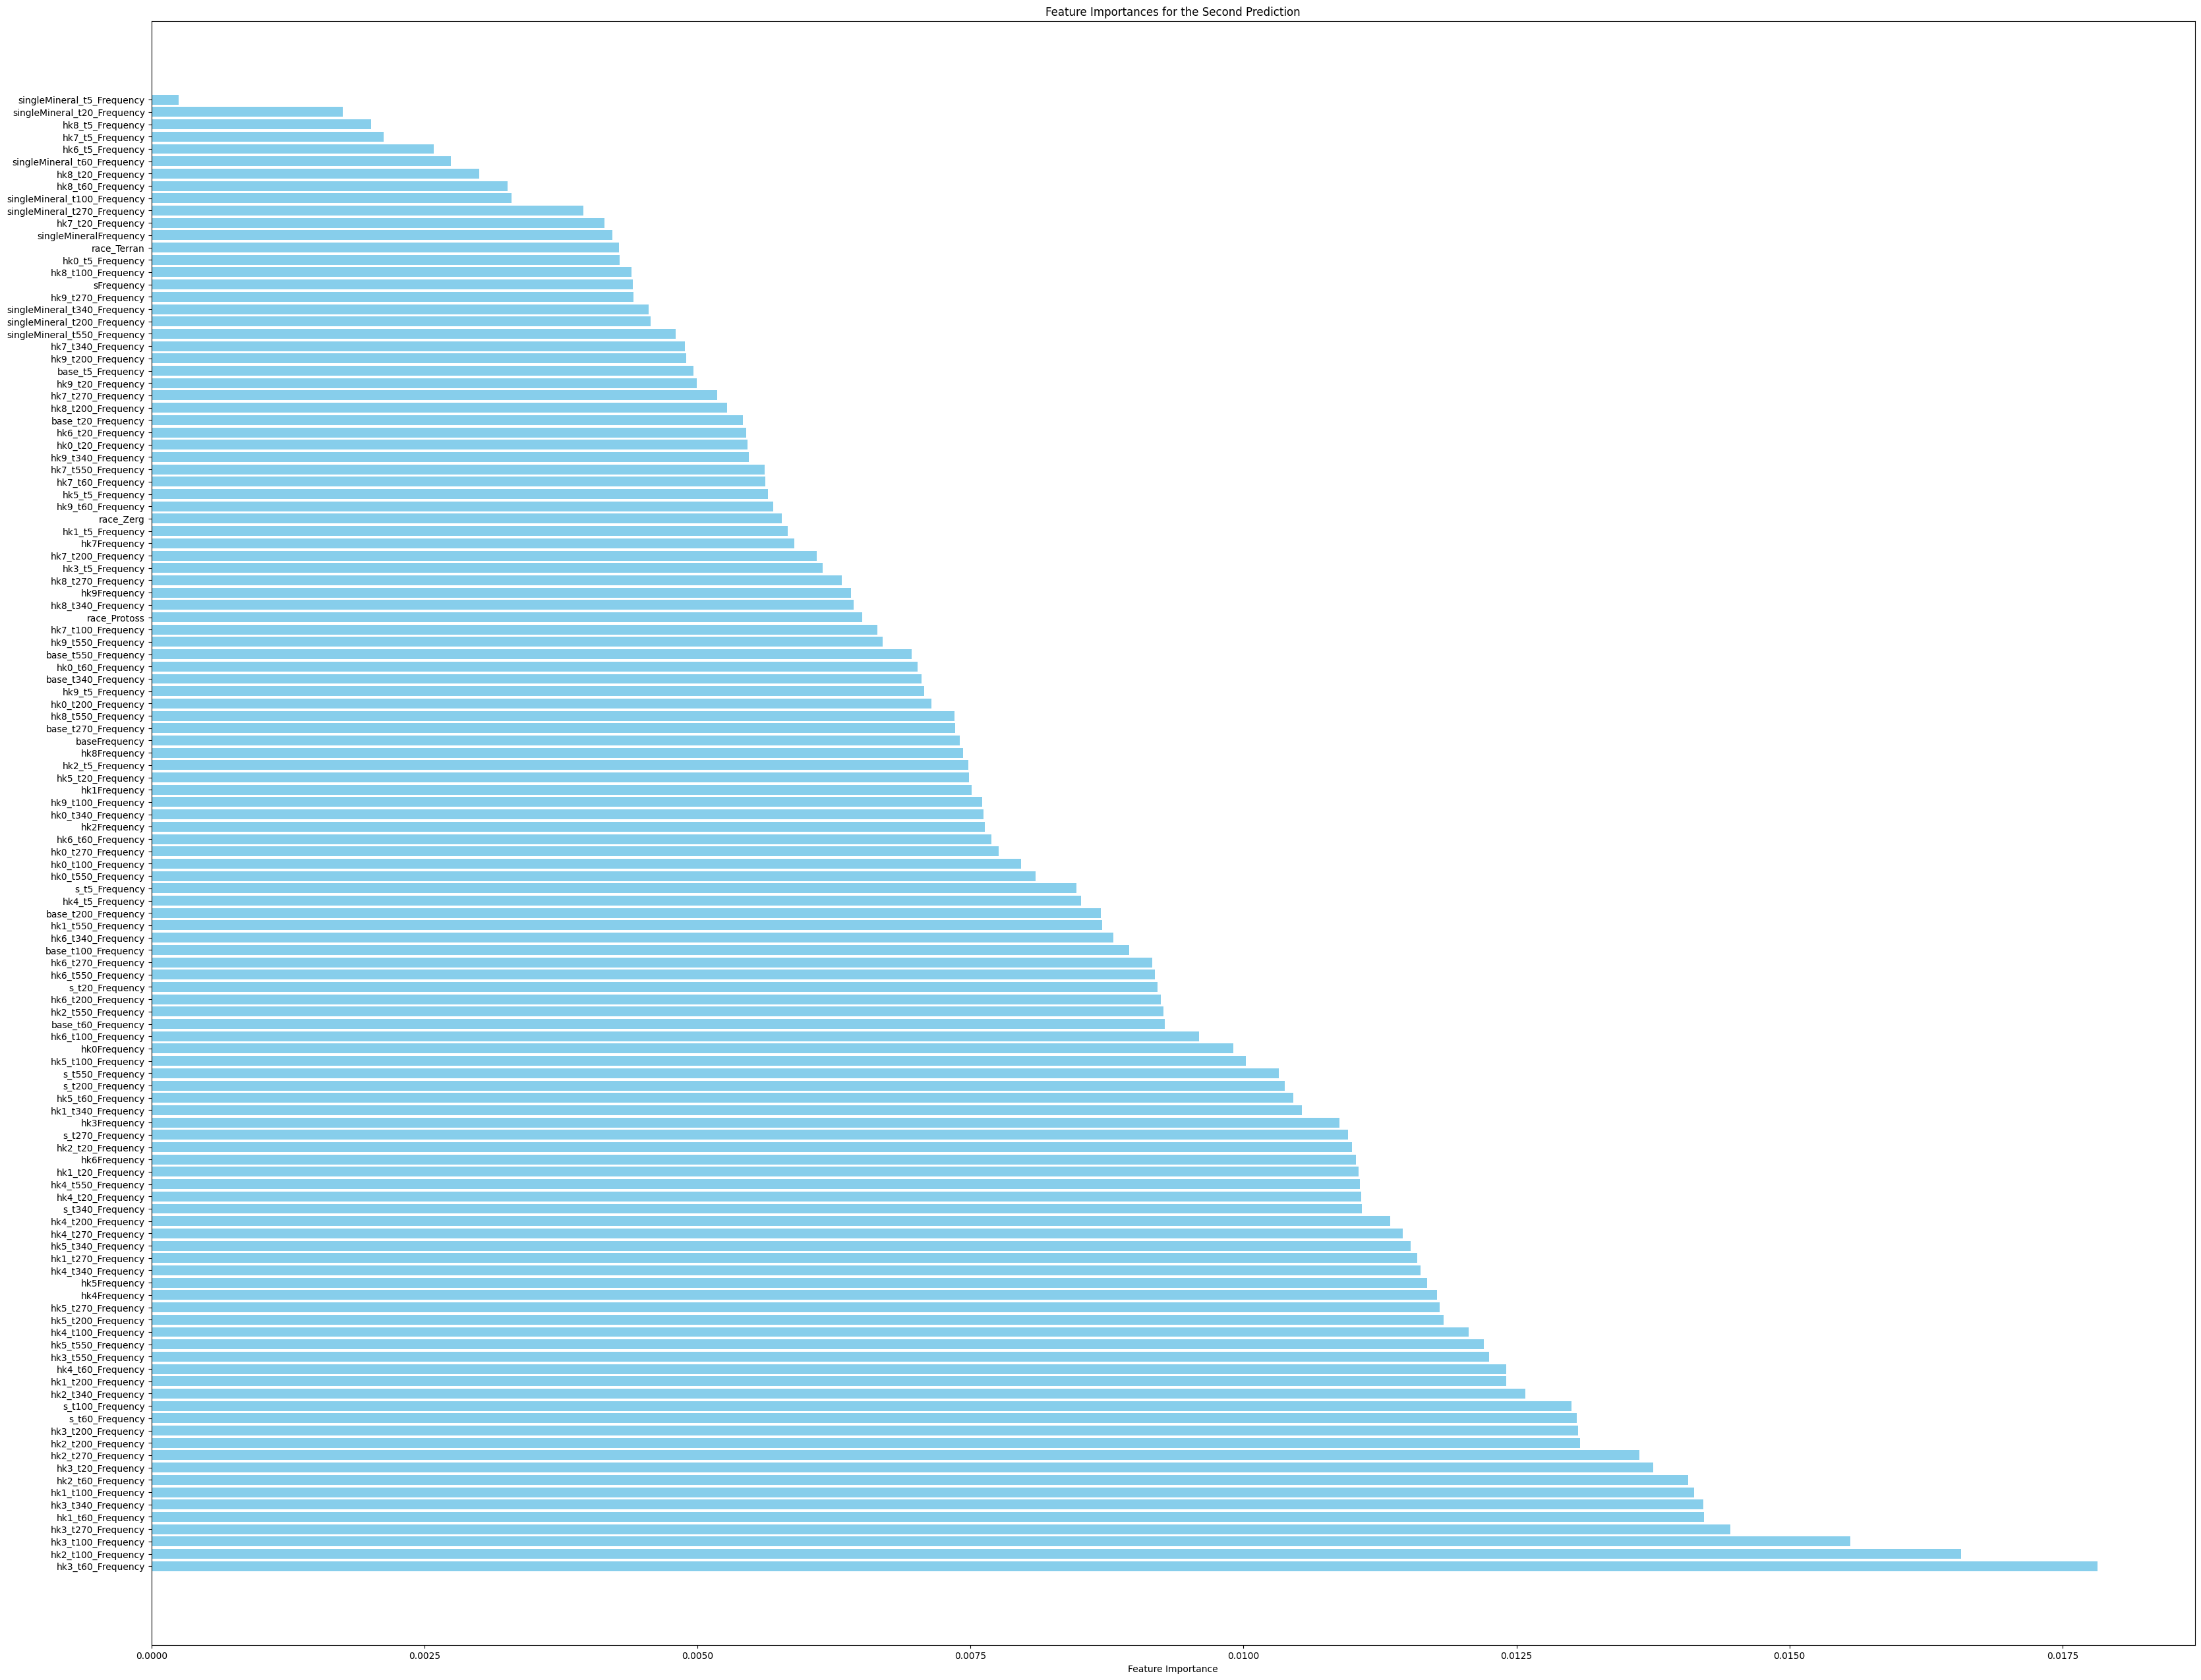

In [14]:
import matplotlib.pyplot as plt

# Load the first row of the features DataFrame (for the first prediction)
first_row_features = features.iloc[[30]]

# Use the loaded model to get the feature importances for the first prediction
prediction_feature_importances = clf.feature_importances_

# Create a DataFrame to store feature names and their importances
prediction_feature_importance_df = pd.DataFrame({
    'Feature': first_row_features.columns,
    'Importance': prediction_feature_importances
})

# Sort the DataFrame by importance in descending order
prediction_feature_importance_df = prediction_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(40, 32))
plt.barh(prediction_feature_importance_df['Feature'], prediction_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances for the Second Prediction')
plt.show()

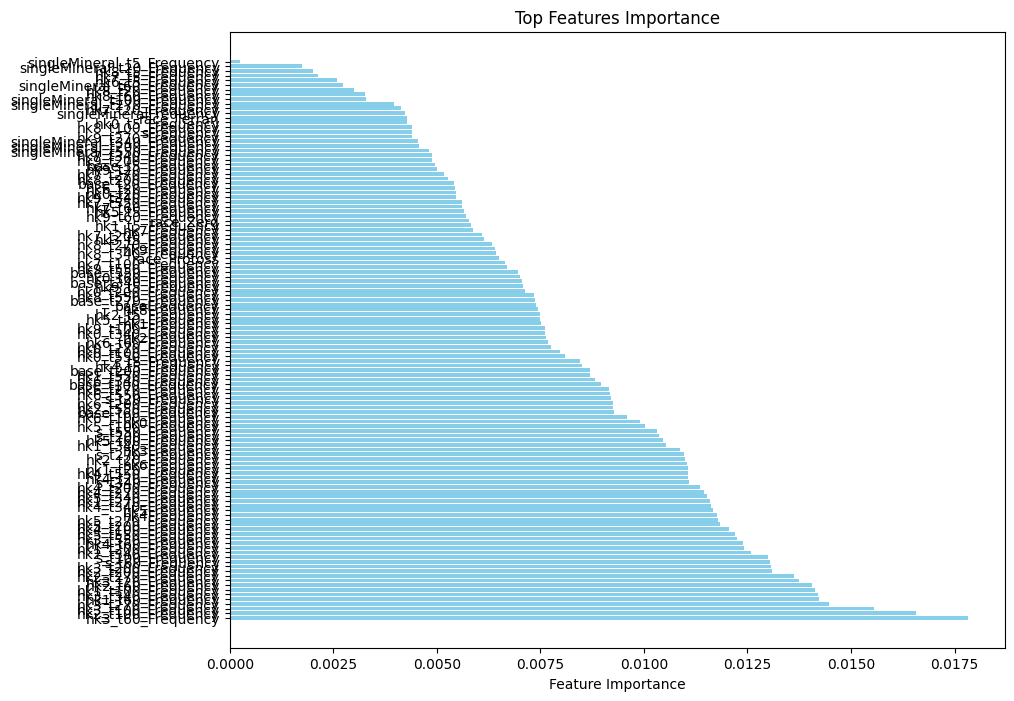

Least Important Features (30%):
['hk1_t5_Frequency', 'race_Zerg', 'hk9_t60_Frequency', 'hk5_t5_Frequency', 'hk7_t60_Frequency', 'hk7_t550_Frequency', 'hk9_t340_Frequency', 'hk0_t20_Frequency', 'hk6_t20_Frequency', 'base_t20_Frequency', 'hk8_t200_Frequency', 'hk7_t270_Frequency', 'hk9_t20_Frequency', 'base_t5_Frequency', 'hk9_t200_Frequency', 'hk7_t340_Frequency', 'singleMineral_t550_Frequency', 'singleMineral_t200_Frequency', 'singleMineral_t340_Frequency', 'hk9_t270_Frequency', 'sFrequency', 'hk8_t100_Frequency', 'hk0_t5_Frequency', 'race_Terran', 'singleMineralFrequency', 'hk7_t20_Frequency', 'singleMineral_t270_Frequency', 'singleMineral_t100_Frequency', 'hk8_t60_Frequency', 'hk8_t20_Frequency', 'singleMineral_t60_Frequency', 'hk6_t5_Frequency', 'hk7_t5_Frequency', 'hk8_t5_Frequency', 'singleMineral_t20_Frequency', 'singleMineral_t5_Frequency']


In [15]:
# Get feature importances from the trained Random Forest classifier
feature_importances = clf.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the top features
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top Features Importance')
plt.show()

# Calculate the threshold for the 30% least important features
threshold = feature_importance_df['Importance'].quantile(0.3)

# Get the least important features
least_important_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()

# Print the least important features
print("Least Important Features (30%):")
print(least_important_features)

In [23]:
# Assuming your RandomForestClassifier is named 'clf'
feature_importances = clf.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Filter features with importance less than 0.01
less_important_features = feature_importance_df[feature_importance_df['Importance'] < 0.0075]['Feature'].tolist()

# Display or use the list of less important features
print("Less Important Features:")
print(less_important_features)

Less Important Features:
['hk1Frequency', 'hk2Frequency', 'hk7Frequency', 'hk8Frequency', 'hk9Frequency', 'sFrequency', 'baseFrequency', 'singleMineralFrequency', 'hk0_t5_Frequency', 'hk1_t5_Frequency', 'hk2_t5_Frequency', 'hk3_t5_Frequency', 'hk5_t5_Frequency', 'hk6_t5_Frequency', 'hk7_t5_Frequency', 'hk8_t5_Frequency', 'hk9_t5_Frequency', 'base_t5_Frequency', 'singleMineral_t5_Frequency', 'hk0_t20_Frequency', 'hk5_t20_Frequency', 'hk6_t20_Frequency', 'hk7_t20_Frequency', 'hk8_t20_Frequency', 'hk9_t20_Frequency', 'base_t20_Frequency', 'singleMineral_t20_Frequency', 'hk0_t60_Frequency', 'hk6_t60_Frequency', 'hk7_t60_Frequency', 'hk8_t60_Frequency', 'hk9_t60_Frequency', 'singleMineral_t60_Frequency', 'hk0_t100_Frequency', 'hk7_t100_Frequency', 'hk8_t100_Frequency', 'hk9_t100_Frequency', 'singleMineral_t100_Frequency', 'hk0_t200_Frequency', 'hk7_t200_Frequency', 'hk8_t200_Frequency', 'hk9_t200_Frequency', 'singleMineral_t200_Frequency', 'hk0_t270_Frequency', 'hk7_t270_Frequency', 'hk8_t2

In [27]:
# Assuming your RandomForestClassifier is named 'clf'
feature_contributions = clf.predict_proba(features)

# Create a DataFrame with feature names and their average contributions
feature_contribution_df = pd.DataFrame({'Feature': features.columns, 'Contribution': feature_contributions.mean(axis=0)})

# Sort the DataFrame by contribution in descending order
feature_contribution_df = feature_contribution_df.sort_values(by='Contribution', ascending=False)

# Plot the top N features and their contribution percentages
top_n = 15  # You can adjust this number based on your preference
plt.figure(figsize=(10, 6))
plt.barh(feature_contribution_df['Feature'][:top_n], feature_contribution_df['Contribution'][:top_n] * 100, color='lightcoral')
plt.xlabel('Contribution (%)')
plt.title(f'Top {top_n} Features Contribution to Predictions')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


ValueError: All arrays must be of the same length

In [29]:
# Assuming your RandomForestClassifier is named 'clf'
feature_contributions = clf.predict_proba(features)

# Create a DataFrame with feature names and their average contributions
feature_contribution_df = pd.DataFrame({'Feature': features.columns, 'Contribution': feature_contributions.mean(axis=0)})

# Sort the DataFrame by contribution in descending order
feature_contribution_df = feature_contribution_df.sort_values(by='Contribution', ascending=False)

# Plot the top N features and their contribution percentages
top_n = 15  # You can adjust this number based on your preference
plt.figure(figsize=(10, 6))
plt.barh(feature_contribution_df['Feature'][:top_n], feature_contribution_df['Contribution'][:top_n] * 100, color='lightcoral')
plt.xlabel('Contribution (%)')
plt.title(f'Top {top_n} Features Contribution to Predictions')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- base_t20_Frequency
- base_t5_Frequency
- hk0_t20_Frequency
- hk0_t5_Frequency
- hk1_t5_Frequency
- ...
